In [1]:
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

In [2]:
hdu = fits.open('/u/ki/mbaumer/for_john/starflat3.resid.fits')

In [44]:
data = hdu[6].data

In [4]:
ext =  hdu["WCSOUT"].data.field("Extension")
row_in_INSTRUMENT = hdu["EXTENSIONS"].data.field("DeviceNumber")[ext]
CCD_name = hdu[2].data.field('Name') [row_in_INSTRUMENT] 

In [43]:
idxs = []
for i,chip in enumerate(CCD_name):
    if len(chip) != 3: continue
    if (chip == ['S', '2', '5']).all():
        idxs.append(i)

In [45]:
thischip = data[idxs]
#thischip = data[np.round(data['Extension']/100) == 1]
#thischip = data[data['SequenceNumber'] == 1]
thischip = thischip[thischip['Reserve'] == 0]

thischip = thischip[thischip['xPix'] >1156]
thischip = thischip[thischip['xPix'] <1816]
thischip = thischip[thischip['yPix'] >132]
thischip = thischip[thischip['yPix'] <3868]

#thischip = thischip[np.sqrt(thischip['xresW']**2+thischip['yresW']**2) > 1]
thischip = thischip[np.sqrt(thischip['xresW']**2+thischip['yresW']**2) < 40]
len(thischip)

8433

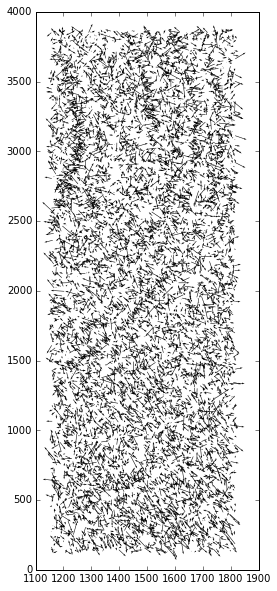

In [46]:
bins=(656/4,3828/4)
plt.figure(figsize=(4,10))
plt.quiver(thischip['xPix'],thischip['yPix'],thischip['xresPix'],thischip['yresPix'],scale=2)

(array([   20.,   105.,   372.,  1204.,  2449.,  2590.,  1239.,   346.,
           91.,    17.]),
 array([-39.50298309, -31.6410347 , -23.7790863 , -15.91713791,
         -8.05518951,  -0.19324112,   7.66870728,  15.53065567,
         23.39260406,  31.25455246,  39.11650085]),
 <a list of 10 Patch objects>)

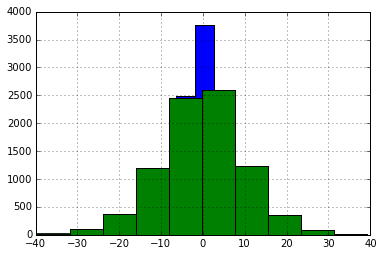

In [166]:
small['Mx'].hist()
plt.hist(270*thischip['xresPix'])

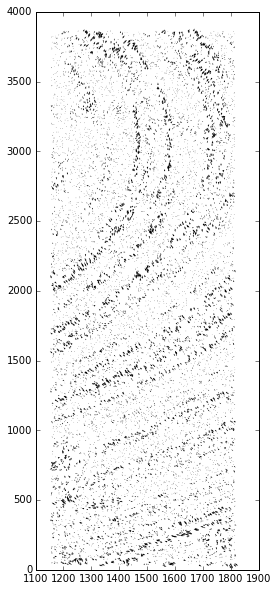

In [172]:
bins=(656/4,3828/4)
plt.figure(figsize=(4,10))
small = feat[np.random.rand(len(feat)) < 0.01]
plt.quiver(small['xctr']+1124,small['yctr'],small['Mx']/270,small['My']/270)

In [159]:
print min(thischip['yPix'])
print min(small['yctr'])

132.102
33.0


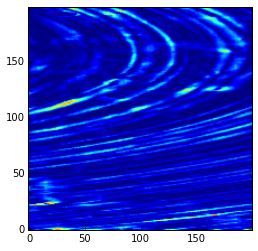

In [108]:
from scipy.stats import binned_statistic_2d
bins=(656/4,3828/4)
plt.figure(figsize=(4,10))
plt.imshow(binned_statistic_2d(feat['yctr'],feat['xctr'],feat['Mx']**2+feat['My']**2,bins=200)[0],origin='lower')

In [8]:
import pandas as pd
#DES
#end_res = pd.read_pickle('/nfs/slac/g/ki/ki19/lsst/mbaumer/scienceImpactDFs/merged/des_betterBRM_psf_src.pkl')
end_res = pd.read_pickle('/nfs/slac/g/ki/ki19/lsst/mbaumer/scienceImpactDFs/for_paper/des_merged.pkl')
feat = pd.DataFrame()
feat['flux'] = end_res['flux']/(.001*np.log(10)/2.5) #convert to mMags
feat[['Mx','My']] = 270*end_res[['Mx','My']] 
feat[['e1','e2']] = end_res[['e1','e2']]
feat['e0'] = (end_res['e0']-end_res['e0'].median())
#feat['inputE'] = np.round(end_res['inputE'].astype(float),decimals=1)
#feat[['inputS', 'inputTheta']] = end_res[['inputS', 'inputTheta']]
feat[['inputPSF','xctr','yctr']] = end_res[['inputPSF','xctr','yctr']]

#feat = feat[np.logical_and(feat['flux'] > -7,feat['flux'] < 7)]


In [9]:
feat.columns

Index([u'flux', u'Mx', u'My', u'e1', u'e2', u'e0', u'inputPSF', u'xctr',
       u'yctr'],
      dtype='object')

In [59]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import NearestNeighbors
X = np.array([feat['xctr']+1024+99,feat['yctr']]).T
#y = np.array([np.abs(feat['Mx']+1j*feat['My'])]).T
y = np.array([feat['Mx']]).T
X2 = np.array([thischip['xPix'],thischip['yPix']]).T
y2 = np.array([thischip['yresPix']]).T
finder = NearestNeighbors(n_neighbors=1).fit(X)
distances, indices = finder.kneighbors(X2)

In [60]:
print min(X[:,0])
print max(X[:,0])
print min(X[:,1])
print max(X[:,1])
print 
print min(X2[:,0])
print max(X2[:,0])
print min(X2[:,1])
print max(X2[:,1])

1156.0
1813.0
33.0
3862.0

1156.03
1815.95
132.102
3868.0


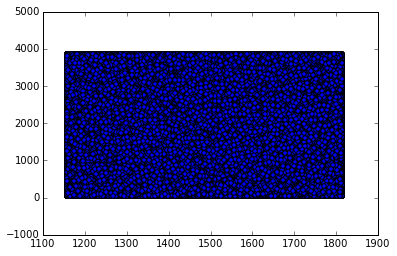

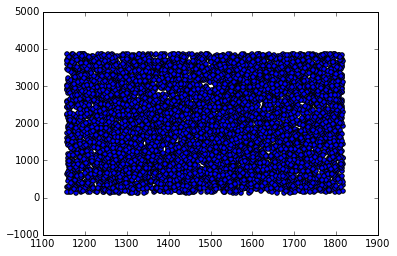

In [54]:
plt.scatter(X[:,0],X[:,1])
plt.figure()
plt.scatter(X2[:,0],X2[:,1])

In [61]:
good_inds = indices[np.where(distances < 1)]
X = X[good_inds]
y = y[good_inds]

nbrs = KNeighborsRegressor(n_neighbors=50)
nbrs.fit(X,y)

nbrs2 = KNeighborsRegressor(n_neighbors=10)
nbrs2.fit(X2,y2)
data = nbrs2.predict(X2)
model = nbrs.predict(X2)

In [62]:
data = np.array([thischip['yresPix']]).T

(array([-0.01326656]), array([ 0.22316329]))


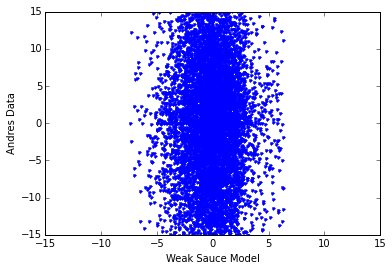

In [63]:
from scipy.stats import pearsonr
plt.plot(model,270*data,'.')
plt.xlabel('Weak Sauce Model')
plt.ylabel('Andres Data')
plt.xlim(-15,15)
plt.ylim(-15,15)
print pearsonr(model,data)

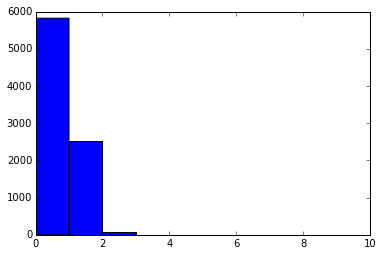

In [58]:
plt.hist(distances.flatten(),range=(0,10),bins=10);

In [35]:
len(good_inds)

277351

In [12]:
len(X)

7089

In [13]:
len(X2)

24383

In [16]:
len(feat['xctr'])

979570

In [44]:
!less '/u/ki/mbaumer/for_john/measured_astrometric_profiles_TREE_RINGS/r_band/tree_rings_binned_astro_res_S25_r_amp_A.dat'

#1 Distrance from ring center (-1090.17, 3141.87) 
#2 Radial component of astrometric residuals)
#3 Error on bin mean (pix) 
1126.25 0.151293 0.0755001
1146.28 -0.0616877 0.0649583
1151.29 -0.0540374 0.038346
1156.3 -0.0597512 0.0148626
1161.3 -0.0530042 0.0400694
1166.31 -0.0935541 0.0163381
1171.32 -0.0781479 0.0229481
1176.33 -0.0804212 0.0516551
1181.33 -0.0524696 0.0179711
1186.34 -0.0216677 0.0144242
1191.35 -0.00821734 0.0210625
1196.35 0.0149042 0.0276395
1201.36 -0.00488656 0.0187265
1206.37 0.0790008 0.0204068
1211.37 0.0509604 0.0135753
1216.38 0.0949378 0.0155831
1221.39 0.0589704 0.0307203
1226.4 0.0894917 0.0435173
1231.4 0.0849138 0.0333257
1236.41 0.0994537 0.0154577
1241.42 0.0729135 0.0304906
:

In [64]:
andres_profile = np.loadtxt('/u/ki/mbaumer/for_john/measured_astrometric_profiles_TREE_RINGS/r_band/tree_rings_binned_astro_res_S25_r_amp_A.dat')

In [65]:
andres_profile.shape

(503, 3)

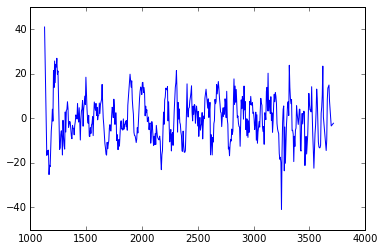

In [66]:
plt.plot(andres_profile[:,0],270*andres_profile[:,1])

In [244]:
import pandas as pd
# trust me on the where argument, cause it cuts the results from 133325455 to 1952357
cat = pd.read_hdf('/nfs/slac/g/ki/ki18/des/cpd/psfex_catalogs/SVA1_FINALCUT/treerings_15_09_30/TreeRings_sva.h5', key='TreeRings', where='ext==4')
# wait five minutes

Opening /nfs/slac/g/ki/ki18/des/cpd/psfex_catalogs/SVA1_FINALCUT/treerings_15_09_30/TreeRings_sva.h5 in read-only mode


In [249]:
cat.columns

Index([u'XWIN_IMAGE', u'YWIN_IMAGE', u'ext', u'x', u'y', u'expnum', u'FLAGS',
       u'SNR_WIN', u'MAG_APER_6', u'psfex_e0', u'data_e0', u'psfex_e1',
       u'data_e1', u'psfex_e2', u'data_e2', u'psfex_e0prime', u'data_e0prime',
       u'psfex_delta1', u'data_delta1', u'psfex_delta2', u'data_delta2',
       u'psfex_zeta1', u'data_zeta1', u'psfex_zeta2', u'data_zeta2',
       u'psfex_fwhm', u'data_fwhm', u'psfex_a4', u'data_a4', u'sample_type'],
      dtype='object')

In [278]:
import matplotlib
bins=(656/2,3828/2)
def makeSystMap(var=np.abs(feat['Mx']+1j*feat['My']),title='Astrometric Shift', cmap=matplotlib.cm.RdBu_r, limits=(None,None),axtitle='Astrometric shift (mas)'):
    num,xe,ye = np.histogram2d(cat['XWIN_IMAGE'],cat['YWIN_IMAGE'],bins=bins,weights=var);
    extent    = [xe[0], xe[-1], ye[0], ye[-1]]
    denom,_,_ = np.histogram2d(cat['XWIN_IMAGE'],cat['YWIN_IMAGE'],bins=bins);
    img = num/denom
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2, 10))
    im = axs.imshow(img.T,cmap=cmap,extent=extent, aspect='auto',origin='lower')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    cbar = plt.colorbar(im, shrink=0.5)
    plt.title(title)
    cbar.set_label(axtitle)

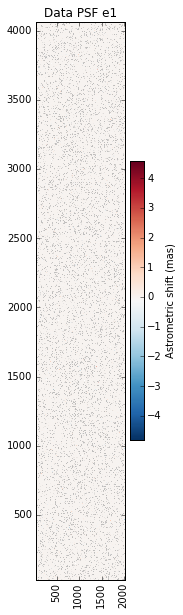

In [280]:
makeSystMap(var=(cat['data_e1']-cat['psfex_e1']),title='Data PSF e1')

In [14]:
from scipy.stats import binned_statistic

In [67]:
def projected_radial_profile(data,center,bins=100,offset=0,**kwargs):
    #data[i] = [xctr,yctr,xres,yres]
    xlocs = data[:,0]
    ylocs = data[:,1]
    xres = data[:,2]
    yres = data[:,3]
    radial_dists = np.sqrt((xlocs-center[0])**2+(ylocs-center[1])**2)
    radial_components = (xres*(xlocs-center[0]) + yres*(ylocs-center[1]))/radial_dists
    num, edges = np.histogram(radial_dists,bins=bins,weights=radial_components)
    denom, edges = np.histogram(radial_dists,bins=bins)
    #profile, edges, _ = binned_statistic(radial_dists,radial_components,bins=bins,statistic='median')
    centers = edges[:-1] + (edges[1]-edges[0])/2
    profile = num/denom
    plt.plot(centers,profile+offset,**kwargs)
    return profile,centers

In [ ]:
data3 = np.array(cat['XWIN_IMAGE'],cat['YWIN_IMAGE'],(cat['']))

In [84]:
print len(andres_profile[25:-15:2,0])
print len(andres)

232
250


In [68]:
from __future__ import division

In [92]:
print min(feat['xctr'])
print max(feat['xctr'])
print min(thischip['xPix'])
print max(thischip['xPix'])

1157.0
1814.0
1156.03
1815.95


(array([ 799.,  888.,  862.,  807.,  885.,  855.,  933.,  780.,  806.,  818.]),
 array([ 1156.03381348,  1222.02506104,  1288.01630859,  1354.00755615,
         1419.99880371,  1485.99005127,  1551.98129883,  1617.97254639,
         1683.96379395,  1749.9550415 ,  1815.94628906]),
 <a list of 10 Patch objects>)

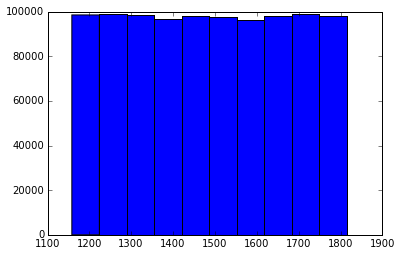

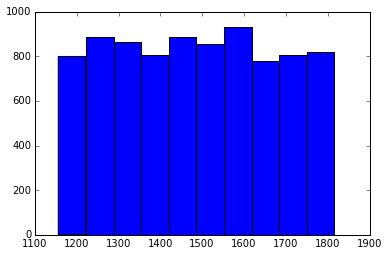

In [122]:
plt.hist(1848-feat['xctr'])
plt.figure()
plt.hist(thischip['xPix'])

(-25, 25)

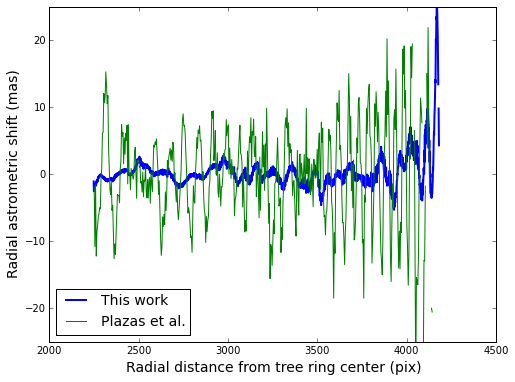

In [160]:
from statsmodels.nonparametric.smoothers_lowess import lowess
data = np.array([feat['xctr']+1124,feat['yctr']+100,feat['Mx'],feat['My']]).T
data2 = np.array([thischip['xPix'],thischip['yPix'],270*thischip['xresPix'],270*thischip['yresPix']]).T

plt.figure(figsize=(8,6))
#a = lowess(270*andres_profile[25:-15,1],andres_profile[25:-15,0],frac=3/len(andres_profile[25:-15,0]))
#plt.plot(a[:,0],a[:,1],color='g',label = 'Plazas et al.')
#good one below
#plt.plot(andres_profile[25:-15,0],270*andres_profile[25:-15,1],color='g',label = 'Plazas et al.')
#andres, edges, _ = binned_statistic(andres_profile[25:-14,0],270*andres_profile[25:-14,1],bins=232)
#width = (andres_profile[26,0]-andres_profile[25,0])
#plt.plot(andres_profile[25:-14:2,0]+width,andres,color='g',label = 'Plazas et al.')
projected_radial_profile(data,center=(-1090.17,3141.87),bins=2000,color='b',linewidth=2,label='This work')
projected_radial_profile(data2,center=(-1090.17,3141.87),bins=500,color='g',linewidth=1,label = 'Plazas et al.')
plt.legend(loc=3,prop={'size':14})
plt.xlabel('Radial distance from tree ring center (pix)',size=14)
plt.ylabel('Radial astrometric shift (mas)',size=14)
plt.ylim(-25,25)
#plt.xlim(2250,3475)

In [213]:
andres_profile.shape

(503, 3)

(array([ 2378.,  2574.,  2374.,  2492.,  2532.,  2481.,  2413.,  2439.,
         2366.,  2334.]),
 array([  150.05885315,   325.052565  ,   500.04627686,   675.03998871,
          850.03370056,  1025.02741241,  1200.02112427,  1375.01483612,
         1550.00854797,  1725.00225983,  1899.99597168]),
 <a list of 10 Patch objects>)

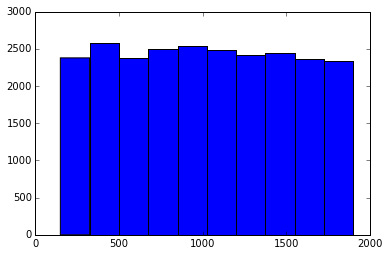

In [210]:
plt.hist(thischip['xPix'])

In [45]:
def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

In [105]:
var = feat['Mx']
num,xe,ye = np.histogram2d(feat['xctr'],feat['yctr'],bins=bins,weights=var);
extent    = [xe[0], xe[-1], ye[0], ye[-1]]
denom,_,_ = np.histogram2d(feat['xctr'],feat['yctr'],bins=bins);
ws_img = num/denom
my_profile = radial_profile(ws_img.T,(-1090.17/4+150,3141.87/4+150))

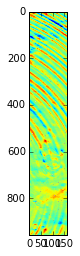

In [103]:
im = plt.imshow(ws_img.T)

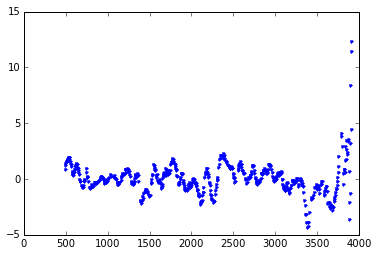

In [107]:
plt.plot(np.arange(len(my_profile))*4,my_profile,'.')

In [45]:
print (max(feat['xctr'])-min(feat['xctr']))
print (max(feat['yctr'])-min(feat['yctr']))
print max(feat['yctr'])
print max(data2[:,0])-min(data2[:,0])

657.0
3829.0
3862.0
1599.95


In [43]:
data2.shape

(20237, 4)

In [99]:
my_profile

array([        nan,         nan,         nan, ...,         nan,
               nan,  1.74740873])